In [1]:
import numpy as np
import faiss
import glob
import json
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import re
import time
from pathlib import Path
import sys

from langdetect import detect

ROOT = Path(os.getcwd()).resolve()

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
WORK_DIR = ROOT.parents[0]

print("Main Work Directory:", WORK_DIR)

Main Work Directory: /home/toonies/Learn/Text_Video_Retrieval


In [2]:
import googletrans
import translate

class Translation:
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate. 
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):
        """
        It takes a string as input, and returns a string with all the letters in lowercase
        :param text: The text to be processed
        :return: The text is being returned in lowercase.
        """
        return text.lower()

    def __call__(self, text):
        """
        The function takes in a text and preprocesses it before translation
        :param text: The text to be translated
        :return: The translated text.
        """
        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'translate' \
                else self.translator.translate(text, dest=self.__to_lang).text


In [10]:
import clip

class MyFaiss:
  def __init__(self, bin_file: str, dict_json: str,device = "cpu", mode = "clip"):    
    self.index = self.load_bin_file(bin_file)
    self.translate = Translation()
    self.dict_json = self._read_json(dict_json)
    self.device = device
    if mode == "clip":
      self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)  
  def load_bin_file(self, bin_file: str):
    return faiss.read_index(bin_file)
  
  def _read_json(self, file_json):
    with open(file_json, "r") as file:
      data = json.load(file)
    return data
      
  def show_images(self, image_paths):
    fig = plt.figure(figsize=(15, 10))
    columns = int(math.sqrt(len(image_paths)))
    rows = int(np.ceil(len(image_paths)/columns))

    for i in range(1, columns*rows +1):
      img = plt.imread(image_paths[i - 1])
      ax = fig.add_subplot(rows, columns, i)
      ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

      plt.imshow(img)
      plt.axis("off")
      
    plt.show()
    
  def text_search(self, text, k):
    if detect(text) == 'vi':
      text = self.translate(text)
    print("Text translation: ", text)
    text = clip.tokenize([text]).to(self.device)  
    text_features = self.model.encode_text(text).cpu().detach().numpy().astype(np.float32)
    scores, idx_image = self.index.search(text_features, k=k)
    print("Idx images", idx_image)
    result_strings = list(map(lambda idx: self.dict_json[idx] if 0 <= idx < len(self.dict_json) else None, idx_image[-1]))
    return result_strings

Type faiss <class 'faiss.swigfaiss_avx2.IndexFlatIP'>
Type json <class 'list'>
Text translation:  A tractor is running in the surrounding green field
Idx images [[3188 3189 3187 3185 3482 3481 3186 3483 3480 3475 3144 3467]]


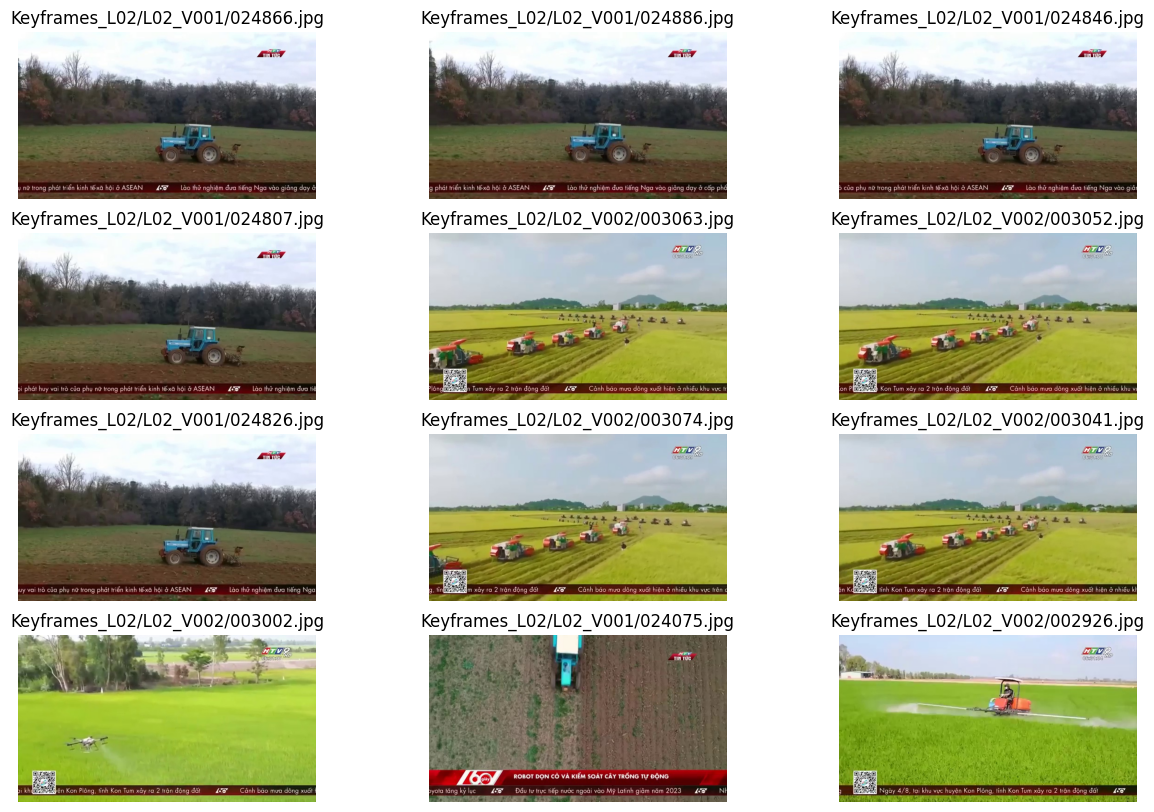

In [11]:
def main():

  ##### TESTING #####
  bin_file=f"{WORK_DIR}/data/dicts/bin_clip/faiss_CLIP_cosine.bin"
  json_path = f"{WORK_DIR}/data/dicts/keyframes_id_search.json"

  cosine_faiss = MyFaiss(bin_file, json_path)


  ##### TEXT SEARCH #####
  text = 'Một chiếc máy cày đang chạy trên cánh đồng xung quanh màu xanh lá'

  
  image_paths = cosine_faiss.text_search(text, k=12)
  # cosine_faiss.write_csv(infos_query, des_path_submit='./')
  base_path = f"{WORK_DIR}/data/"

  # Tạo đường dẫn tuyệt đối cho từng hình ảnh
  img_paths = [os.path.join(base_path, image_path) for image_path in image_paths]
  cosine_faiss.show_images(img_paths)

if __name__ == "__main__":
    main()